# Precipitation regrid 

## 1 Overview

- **Main ideas:**
    - This notebook makes the PERSIANN-CDR precipitation data (monthly sum) spatially compatible with ERA-INTERIM data grid: 
        - PERSIANN-CDR:
            - lat: 480, lon: 1440; 0.25 x 0.25 degrees; not global because latitude is between 60S and 60N.
        - ERA-INTERIM: 
            - lat: 161, lon: 480; 0.75 x 0.75 degrees; latitude between 60S and 60N. 
    - First we had calculated the monthly cumulative rainfall from the original daily data from PERSIANN-CDR. These calculations can be found on the following notebook: [precipitation_persiann_cdr_msum.ipynb](../single_variables/precipitation_persiann_cdr_msum.ipynb).
    - Compare original and regridded data in South America by means of monthly climatologies and time series.
    - [Regridding overview](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview).
    - [ESMP : ESMF Python interface](https://www.earthsystemcog.org/projects/esmp/).

## 2 Initial setup

In [1]:
# Load packages.
import os
import glob
import warnings

import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from datetime import datetime
from dask.diagnostics import ProgressBar
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")

%matplotlib inline

In [2]:
# Original data.
FOLDER_IN = "/media/alex/ALEXDATA/data_sets/PERSIANN_CDR/MSUM/"

# All files there.
FILES_IN = sorted(glob.glob(FOLDER_IN + "*.nc"))

In [3]:
# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [4]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## 3 Create regridder file

In [5]:
%%time

# As xarray Dataset object. Just the first file for creating the regrid file.
DS = xr.open_dataset(FILES_IN[0])

CPU times: user 19.1 ms, sys: 127 ms, total: 146 ms
Wall time: 404 ms


In [6]:
# Let's see it. 
DS

<xarray.Dataset>
Dimensions:        (lat: 480, lon: 1440, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 1983-01-01 1983-02-01 ... 1983-12-01
  * lat            (lat) float32 -59.875 -59.625 -59.375 ... 59.625 59.875
  * lon            (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes:
    datetime:                   1983-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.1983.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    id:                         PERSIANN-CDR_v01r01_19830101_c20140523.nc
    naming_authority:           gov.noaa.ncdc
    date_created:               2014-05-23T02:41:51Z
    license:                    No constraints on data access or use.
    summary:                    Daily near global precipitation estimates at ...
    keywords:                   EARTH SCIENCE > ATMOSPHERE > PRECIPITATION
    keywords_vocabulary:        GCMD Keywords, Version 8.0.0.0.0
    cdm_data_type:              Grid
    project:                    Satellite Data Support for Hydrologic and Wat...
    creator_name:               Dan Braithwaite
    creator_email:              dbraithw@uci.edu
    creator_url:                http://www.chrs.web.uci.edu/
    institution:                UC-IRVINE/CHRS, Center for Hydrometeorology a...
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1983-01-01T00:00Z
    time_coverage_end:          1983-01-01T23:59Z
    contributor_name:           Soroosh Sorooshian, Kuolin Hsu, Hamed Ashouri...
    contributor_role:           PrincipalInvestigator, Professor, Author, Author
    cdr_program:                NOAA Climate Data Record Program
    cdr_variable:               precipitation
    metadata_link:              gov.noaa.ncdc:C00854
    product_version:            v01r01
    spatial_resolution:         0.25 degrees
    build:                      Monthly cumulative values by Alex Araujo
    build_date:                 June 03, 2020; 16h:26min:58s

In [7]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180 and putting latitude in ascending order). 
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(-60.00, 60.00 + 0.75, 0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

# Show it.
NEW_GRID

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 480)
Coordinates:
  * lat      (lat) float64 -60.0 -59.25 -58.5 -57.75 ... 57.75 58.5 59.25 60.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*

In [8]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS,
    ds_out=NEW_GRID,
    method="bilinear",
    periodic=True,
    filename=None,
    reuse_weights=True
)

# Show it.
REGRIDDER

Create weight file: bilinear_480x1440_161x480.nc
CPU times: user 11 s, sys: 384 ms, total: 11.4 s
Wall time: 11.4 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_480x1440_161x480.nc 
Reuse pre-computed weights? True 
Input grid shape:           (480, 1440) 
Output grid shape:          (161, 480) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

## 4 Build new regridded files

In [9]:
%%time

# Message.
print("In", FOLDER_IN + " :")

# Loop over input files.
for FILE_IN in FILES_IN:
        
    # Extract input file name without extension.
    name = os.path.basename(FILE_IN) # File name with extension.
    name = os.path.splitext(name)[0] # File name without extension.
    
    # Out put file path.
    out_file_name = name + "_regridded" + ".nc4"
    out_file_path = FOLDER_IN + out_file_name    
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(out_file_path):    
    
        # Message.
        print("Creating", out_file_name, end=" ")
        
        # Read data.
        DS = xr.open_dataset(FILE_IN) # Xarray Dataset object.
                
        # Regrid data.
        DS = REGRIDDER(DS)
    
        # My additional attributes.
        now = datetime.now()
        now_str = now.strftime("%B %d, %Y; %Hh:%Mmin:%Ss")
        DS.attrs["build"] = "Monthly cumulative regridded values by Alex Araujo"
        DS.attrs["build_date"] = now_str    
    
        # Export regridded data (same time resolution as the original data) into the input 
        # folder. 
        DS.to_netcdf(path=out_file_path)
        
    else:
        
        # Message.
        print("Warning:", out_file_name, "has already been created!")

In /media/alex/ALEXDATA/data_sets/PERSIANN_CDR/MSUM/ :
Creating msum_precipitation_1983_regridded.nc4 using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
Creating msum_precipitation_1984_regridded.nc4 using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
Creating msum_precipitation_1985_regridded.nc4 using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
Creating msum_precipitation_1986_regridded.nc4 using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
Creating msum_precipitation_1987_regridded.nc4 using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
Creating msum_precipitation_1988_regridded.nc4 using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this 

## 5 Compare original and regridded data

In [10]:
# Original files.
FILES_ori = sorted(glob.glob(FOLDER_IN + "*.nc"))

# 2020 data does not have the correct time stamp.
FILES_ori = FILES_ori[:-1]

# Lazy load original data.
DS_ori = xr.open_mfdataset(FILES_ori, concat_dim="time", combine="nested")
DS_ori

<xarray.Dataset>
Dimensions:        (lat: 480, lon: 1440, time: 444)
Coordinates:
  * lon            (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat            (lat) float32 -59.875 -59.625 -59.375 ... 59.625 59.875
  * time           (time) datetime64[ns] 1983-01-01 1983-02-01 ... 2019-12-01
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(12, 480, 1440), meta=np.ndarray>
Attributes:
    datetime:                   1983-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.1983.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    id:                         PERSIANN-CDR_v01r01_19830101_c20140523.nc
    naming_authority:           gov.noaa.ncdc
    date_created:               2014-05-23T02:41:51Z
    license:                    No constraints on data access or use.
    summary:                    Daily near global precipitation estimates at ...
    keywords:                   EARTH SCIENCE > ATMOSPHERE > PRECIPITATION
    keywords_vocabulary:        GCMD Keywords, Version 8.0.0.0.0
    cdm_data_type:              Grid
    project:                    Satellite Data Support for Hydrologic and Wat...
    creator_name:               Dan Braithwaite
    creator_email:              dbraithw@uci.edu
    creator_url:                http://www.chrs.web.uci.edu/
    institution:                UC-IRVINE/CHRS, Center for Hydrometeorology a...
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1983-01-01T00:00Z
    time_coverage_end:          1983-01-01T23:59Z
    contributor_name:           Soroosh Sorooshian, Kuolin Hsu, Hamed Ashouri...
    contributor_role:           PrincipalInvestigator, Professor, Author, Author
    cdr_program:                NOAA Climate Data Record Program
    cdr_variable:               precipitation
    metadata_link:              gov.noaa.ncdc:C00854
    product_version:            v01r01
    spatial_resolution:         0.25 degrees
    build:                      Monthly cumulative values by Alex Araujo
    build_date:                 June 03, 2020; 16h:26min:58s

In [11]:
# Into memory.
with ProgressBar():
    DS_ori = DS_ori.compute()

[########################################] | 100% Completed |  0.5s


In [12]:
# New files.
FILES_reg = sorted(glob.glob(FOLDER_IN + "*regridded.nc4"))

# 2020 data does not have the correct time stamp.
FILES_reg = FILES_reg[:-1]

# Lazy load data.
DS_reg = xr.open_mfdataset(FILES_reg, concat_dim="time", combine="nested")
DS_reg

<xarray.Dataset>
Dimensions:        (lat: 161, lon: 480, time: 444)
Coordinates:
  * lon            (lon) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * lat            (lat) float64 -60.0 -59.25 -58.5 -57.75 ... 58.5 59.25 60.0
  * time           (time) datetime64[ns] 1983-01-01 1983-02-01 ... 2019-12-01
Data variables:
    precipitation  (time, lat, lon) float64 dask.array<chunksize=(12, 161, 480), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear
    build:          Monthly cumulative regridded values by Alex Araujo
    build_date:     June 06, 2020; 00h:06min:20s

In [13]:
# Into memory.
with ProgressBar():
    DS_reg = DS_reg.compute()

[########################################] | 100% Completed |  0.2s


### 5.1 Monthly climatologies in South America

In [14]:
%%time

# Monthly means.
DA_ori_mm = DS_ori.precipitation.groupby("time.month").mean("time").\
                   sel(lat=slice(lati, latf), lon=slice(loni, lonf))
DA_reg_mm = DS_reg.precipitation.groupby("time.month").mean("time").\
                   sel(lat=slice(lati, latf), lon=slice(loni, lonf))

CPU times: user 1.45 s, sys: 3.1 ms, total: 1.45 s
Wall time: 1.48 s


CPU times: user 11.4 s, sys: 233 ms, total: 11.6 s
Wall time: 8.93 s


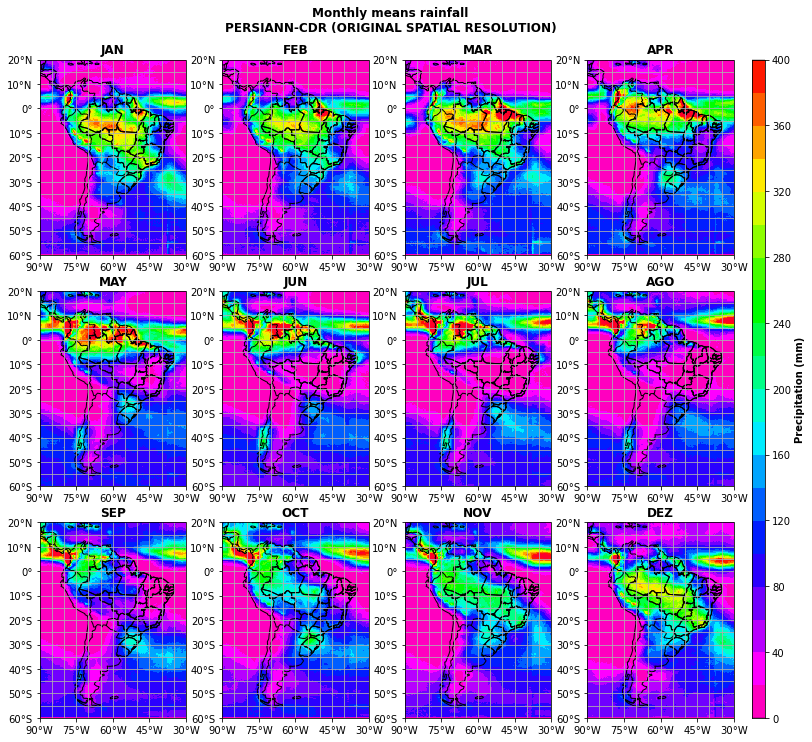

In [15]:
%%time

months_labels = [
    "JAN", "FEB", "MAR", "APR", 
     "MAY", "JUN", "JUL", "AGO", 
     "SEP", "OCT", "NOV", "DEZ"
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(13, 12))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 4),
    axes_pad=0.5,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = DA_ori_mm.isel(month=index).plot(
        ax=axis,
        vmin=0,
        vmax=400,
        levels=np.arange(0, 420, 20),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(months_labels[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(
    label="Precipitation (mm)", 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(0, 440, 40))        
plt.suptitle(
    "Monthly means rainfall\nPERSIANN-CDR (ORIGINAL SPATIAL RESOLUTION)", 
    weight="bold"
)
plt.subplots_adjust(top=0.95)

# Save figures.
plt.savefig(
    fig_path + "precipitation_persianncdr_cum_mmeans_ori.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

CPU times: user 8.44 s, sys: 163 ms, total: 8.61 s
Wall time: 5.52 s


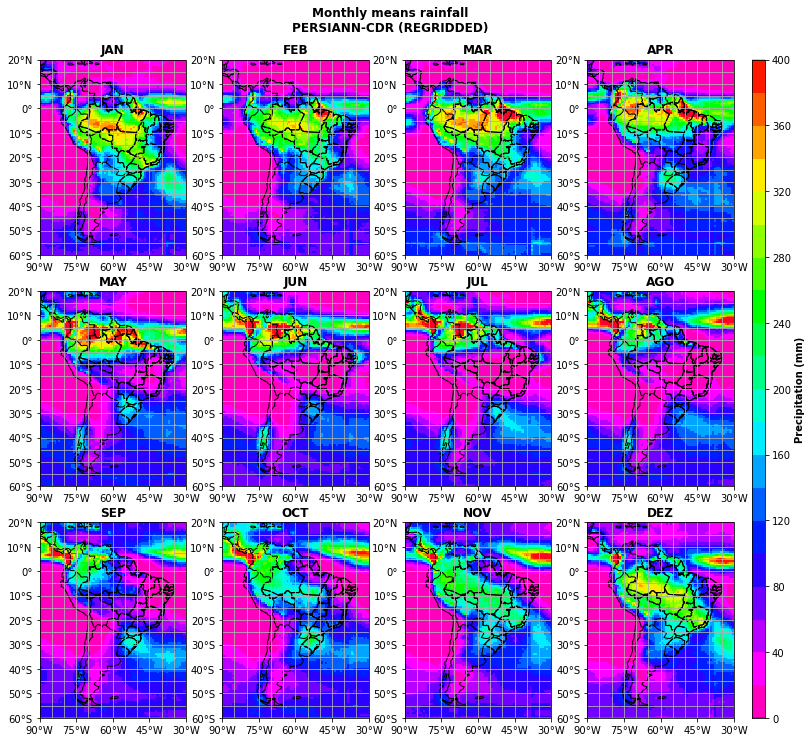

In [16]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(13, 12))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 4),
    axes_pad=0.5,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = DA_reg_mm.isel(month=index).plot(
        ax=axis,
        vmin=0,
        vmax=400,
        levels=np.arange(0, 420, 20),
        cmap=plt.cm.gist_rainbow_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(months_labels[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(
    label="Precipitation (mm)", 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(0, 440, 40))        
plt.suptitle(
    "Monthly means rainfall\nPERSIANN-CDR (REGRIDDED)", 
    weight="bold"
)
plt.subplots_adjust(top=0.95)

# Save figures.
plt.savefig(
    fig_path + "precipitation_persianncdr_cum_mmeans_reg.jpg", 
    dpi=200, 
    bbox_inches="tight"
)

### 5.2 Time series

CPU times: user 53.9 ms, sys: 4.09 ms, total: 58 ms
Wall time: 56.4 ms


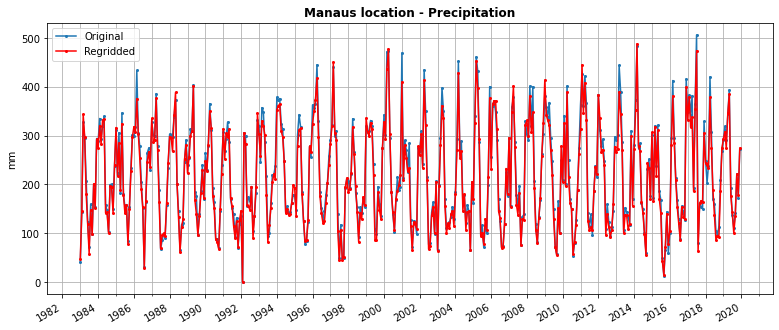

In [17]:
%%time

# Make figure and axes.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))
yl = mdates.YearLocator(2)
yl2 = mdates.YearLocator(1)
yl_fmt = mdates.DateFormatter("%Y")

# Manaus location.
DS_ori.precipitation.sel(lat=-3, lon=-60, method="nearest").\
                     plot(ax=ax, marker="o", ms=2, label="Original")
DS_reg.precipitation.sel(lat=-3, lon=-60, method="nearest").\
                     plot(ax=ax, marker="o", color="red", ms=2, label="Regridded")
ax.set_ylabel("mm")
ax.set_xlabel(None)
ax.set_title("Manaus location - Precipitation", weight="bold")
ax.xaxis.set_major_locator(yl)
ax.xaxis.set_minor_locator(yl2)
ax.xaxis.set_major_formatter(yl_fmt)
ax.grid(which="both")
_ = ax.legend()

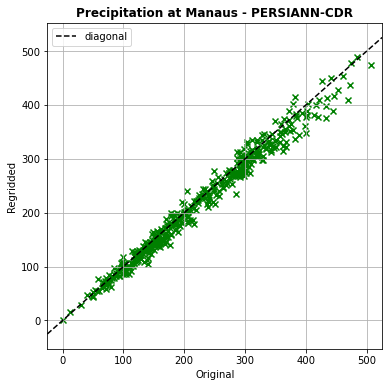

In [18]:
# Scatter plot.
plt.figure(figsize=(6, 6))
plt.scatter(
    DS_ori.precipitation.sel(lat=-3, lon=-60, method="nearest").values,
    DS_reg.precipitation.sel(lat=-3, lon=-60, method="nearest").values,
    marker="x", 
    color="green"
)
plt.xlim((-25, 525))
p = plt.gca().get_xlim()
plt.xlabel("Original")
plt.ylabel("Regridded")
plt.title("Precipitation at Manaus - PERSIANN-CDR", weight="bold")
plt.plot(p, p, "--k", label="diagonal")
plt.legend()
plt.grid();